# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

[Deep Learning for Coders with fastai & PyTorch](https://github.com/fastai/fastbook) de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the [LICENSE file](https://github.com/fastai/fastbook/blob/master/LICENSE) for details.

In [3]:
from fastai2.vision.all import *

# Configuration spécifique pour show_image() sur ce dataset : images en niveaux de gris
matplotlib.rc('image', cmap='Greys')

# Les fondamentaux - Entrainer un classifier de chiffres manuscrits

Le jeu de données MNIST : le "Hello World" du deep learning
- [images](https://www.google.com/search?q=mnist+dataset&tbm=isch)
- [historique](https://en.wikipedia.org/wiki/MNIST_database)

## Pixels: comment un ordinateur représente des images

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('C:/Users/laure/.fastai/data/mnist_sample')

In [5]:
path.ls()

(#3) [Path('C:/Users/laure/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/laure/.fastai/data/mnist_sample/train'),Path('C:/Users/laure/.fastai/data/mnist_sample/valid')]

In [6]:
(path/'train').ls()

(#2) [Path('C:/Users/laure/.fastai/data/mnist_sample/train/3'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10000.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10011.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10031.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10034.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10042.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10052.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/1007.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10074.png'),Path('C:/Users/laure/.fastai/data/mnist_sample/train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
im3_t = tensor(im3)
im3_t[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Première tentative: similarité des pixels

In [12]:
# Python syntax : list comprehensions
[i*2 for i in range(10) if i > 4]

[10, 12, 14, 16, 18]

In [13]:
# Ouverture de 1200 images, 15 à 30 secondes
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [14]:
im3_t = three_tensors[1]
im3_t.shape

torch.Size([28, 28])

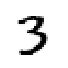

In [15]:
show_image(im3_t)

[torch.stack(tensors, dim=0, out=None) → Tensor](https://pytorch.org/docs/stable/torch.html#torch.stack)

Concatenates sequence of tensors **along a new dimension**.
All tensors need to be of the same size.

In [193]:
type(three_tensors),type(three_tensors[0]),three_tensors[0].shape

(list, torch.Tensor, torch.Size([28, 28]))

In [16]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [17]:
len(stacked_threes.shape)

3

In [18]:
stacked_threes.ndim

3

In [19]:
stacked_threes[1,4:10,4:10]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1137],
        [0.0000, 0.0000, 0.0000, 0.1882, 0.6510, 0.8784],
        [0.0000, 0.3647, 0.9569, 0.9765, 0.9922, 0.7333],
        [0.0000, 0.4196, 0.9922, 0.9922, 0.9020, 0.1882],
        [0.0000, 0.0118, 0.0784, 0.0784, 0.0588, 0.0000]])

In [20]:
mean3 = stacked_threes.mean(0)
mean3.shape

torch.Size([28, 28])

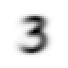

In [21]:
show_image(mean3);

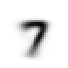

In [22]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

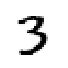

In [23]:
a_3 = stacked_threes[1]
show_image(a_3);

Comment calculer l'erreur ?
- différence pixel par pixel
- on ne peut pas juste sommer les différences positives et négatives ...
- norme L1 : somme des valeurs absolues, norme L2 : somme des valeurs au carré

In [24]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

Ci-dessous :
- opérations élément par élément entre deux tensors
- fonctions appliquées "element-wise" sur un tensor

In [25]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

Ces fonctions de mesure de l'erreur (loss functions) font déjà définie par Pytorch dans le module :
- import torch.nn.functional as F
- norme L1 : F.l1_loss
- norme L2 : F.mse_loss (mean squared error)

In [26]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy arrays et PyTorch tensors

In [27]:
data = [[1,2,3],
        [4,5,6]]
arr = array (data)
tns = tensor(data)

In [28]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

Avantages des tableaux numpy par rapport aux listes Python
- tableaux de tableaux de différentes tailles
- CPU uniquement
- exécution 10 000 x plus rapide que Python : algorithmes C optimisés, parallélisme

In [29]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

Caractéristiques des tensors PyTorch
- tableaux réguliers uniquement
- CPU et GPU
- exécution 1 000 000 x plus rapide que Python : algorithmes Cuda optimisés, parallélisme massif
- calcul automatique des dérivées des fonctions appliquées (cf plus bas)

Indexing & Slicing :

In [30]:
# 1ère ligne
tns[1]

tensor([4, 5, 6])

In [31]:
# 1ère colonne
tns[:,1]

tensor([2, 5])

In [32]:
# 1ère ligne, 2ème et 3ème colonnes
tns[1,1:3]

tensor([5, 6])

In [33]:
# Opérations element-wise
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [34]:
tns.type()

'torch.LongTensor'

In [35]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Calculer des métriques efficacement en utilisant le broadcasting

In [36]:
# Images - training set
train_3_tens=stacked_threes
train_7_tens=stacked_sevens
train_3_tens.shape,train_7_tens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [37]:
# Images - validation set
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [38]:
def mnist_distance(a,b): 
    return (a-b).abs().mean((-1,-2))

In [39]:
mnist_distance(a_3, mean3)

tensor(0.1114)

In [40]:
a_3.shape,mean3.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

In [41]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)

In [42]:
valid_3_tens.shape, mean3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

In [43]:
valid_3_dist.shape, valid_3_dist

(torch.Size([1010]),
 tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]))

In [44]:
tensor([1,2,3]) + tensor([1])

tensor([2, 3, 4])

In [45]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [46]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

**Règles du broadcasting** dans numpy et PyTorch :
1. Si les tableaux n'ont pas le même rang, préfixer la forme du tableau de rang inférieur avec des 1 jusqu'à ce que les deux formes aient la même longueur.
2. Les deux tableaux sont compatibles dans une dimension :
   - s'ils ont la même taille dans la dimension
   - ou si l'un des tableaux a la taille 1 dans cette dimension.
3. Chaque tableau se comporte comme s'il avait une forme égale au maximum des formes des deux tableaux d'entrée. Dans toute dimension où un tableau a une taille de 1 et l'autre tableau a une taille supérieure à 1, le premier tableau se comporte comme s'il était copié dans cette dimension.

**Comparaison de performance**

In [47]:
def mnist_distance_python():
    distances = L()
    for img_index in range(valid_3_tens.shape[0]):
        img_tens = valid_3_tens[img_index]
        differences = []
        for x in range(img_tens.shape[0]):
            for y in range(img_tens.shape[1]):
                differences.append(img_tens[x,y]-mean3[x,y])
        dist = 0
        for diff in differences:
            dist = dist + abs(diff)
        mean = dist/len(differences)
        distances.append(mean)
    return distances

In [48]:
%time mnist_distance_python()

Wall time: 36.4 s


(#1010) [tensor(0.1280),tensor(0.1623),tensor(0.1242),tensor(0.1469),tensor(0.1202),tensor(0.1188),tensor(0.1700),tensor(0.1266),tensor(0.1337),tensor(0.1183)...]

In [49]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [55]:
%time mnist_distance(valid_3_tens, mean3)

Wall time: 4.46 ms


tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

Pytorch broadcasting :
- 1 ligne de code flexible (forme des données passées) vs 13 lignes de code non adaptables
- déjà **10 000 x plus rapide** sur CPU

Prédiction du résultat :

In [51]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [52]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [53]:
%time is_3(valid_3_tens)

Wall time: 7.98 ms


tensor([ True,  True,  True,  ..., False,  True,  True])

Métrique **accuracy** : sur 100 prédictions, combien de fois la prédiction est-elle conforme au label attendu ?

In [54]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Importance d'une **baseline** simple : cette approche nous donne déjà un résultat correct dans 95% des cas.

Attention, nous n'avions que deux chiffres bien différents à distinguer ...

## Stochastic Gradient Descent (SGD)

In [75]:
# Utilitaire
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

Appliquons le principe du machine learning sur un cas simple d'abord.

L'objectif est de **modifier progressivement les paramètres du modèle** pour **réduire l'erreur de prédiction**.

On représente ci-dessous une vision simplifiée dont l'erreur de prédiction peut varier en fonction d'un paramètre x à ajuster.

In [89]:
def loss_function(x): return x**2

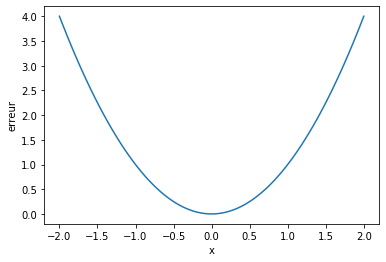

In [90]:
plot_function(loss_function, 'x', 'erreur')

A la fin de l'itération précédente, le paramètre x vaut -1,5.
- faut-il l'augmenter (point vert) ou le réduire (point rouge) pour faire diminuer l'erreur de prédiction à l'itération suivante ?
- de combien faut-il l'augmenter ou le réduire pour se rapprocher du minimum ?

Nous avons besoin de savoir comment varie l'erreur de prédiction si on modifie légèrement le paramètre autour de la valeur -1.5.

In [94]:
x_val = -1.5
error_val = loss_function(x_val)
error_val

2.25

In [92]:
epsilon = 0.1
x_val_plus = x_val+epsilon
x_val_minus = x_val-epsilon
x_val_minus,x_val,x_val_plus

(-1.6, -1.5, -1.4)

In [93]:
error_val_plus = loss_function(x_val_plus)
error_val_minus = loss_function(x_val_minus)
error_val_minus,error_val,error_val_plus

(2.5600000000000005, 2.25, 1.9599999999999997)

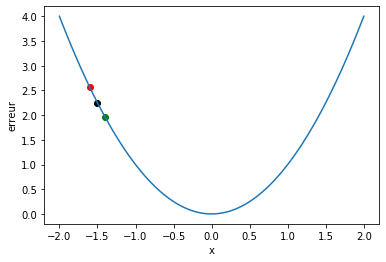

In [95]:
plot_function(f, 'x', 'erreur')
plt.scatter(x_val, error_val, color='black');
plt.scatter(x_val_minus, error_val_minus, color='red');
plt.scatter(x_val_plus, error_val_plus, color='green');

In [99]:
error_variation_when_x_changes = (error_val_plus - error_val_minus)/(x_val_plus - x_val_minus)
error_variation_when_x_changes

-3.000000000000001

### Itérations (steps) pas à pas (learning rate)

In [107]:
learning_rate = 0.3
x_better_val = x_val - (error_variation_when_x_changes * learning_rate)
x_val,x_better_val

(-1.5, -0.5999999999999998)

In [108]:
error_better_val = loss_function(x_better_val)
error_val,error_better_val

(2.25, 0.3599999999999997)

Programme automatique pour trouver la valeur du paramètre x qui minimise l'erreur observée :

In [120]:
def train_parameter(iterations_count=10, learning_rate=0.1):
    plot_function(f, 'x', 'erreur')

    # random init
    x = -2.    
    # initial error value
    error = loss_function(x)
    # plot starting point
    plt.scatter(x, error, color='black');

    for iteration in range(iterations_count):
        x_p = x + 0.01
        x_m = x - 0.01
        error_p = loss_function(x_p)
        error_m = loss_function(x_m)
        error_variation_when_x_changes = (error_p - error_m)/(x_p - x_m)
        x = x - (error_variation_when_x_changes * learning_rate)
        error = loss_function(x)
        # display current results
        print(f"#{iteration} : loss = {error:.3f}")
        plt.scatter(x, error, color='black');
        
    return x, error

#0 : loss = 2.560
#1 : loss = 1.638
#2 : loss = 1.049
#3 : loss = 0.671
#4 : loss = 0.429
#5 : loss = 0.275
#6 : loss = 0.176
#7 : loss = 0.113
#8 : loss = 0.072
#9 : loss = 0.046


(-0.21474836480000026, 0.04611686018427399)

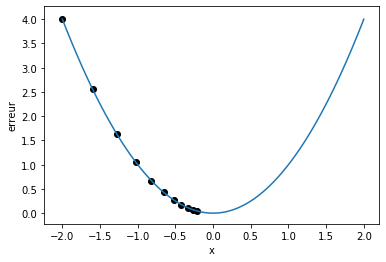

In [121]:
train_parameter()

#0 : loss = 2.560
#1 : loss = 1.638
#2 : loss = 1.049
#3 : loss = 0.671
#4 : loss = 0.429
#5 : loss = 0.275
#6 : loss = 0.176
#7 : loss = 0.113
#8 : loss = 0.072
#9 : loss = 0.046
#10 : loss = 0.030
#11 : loss = 0.019
#12 : loss = 0.012
#13 : loss = 0.008
#14 : loss = 0.005
#15 : loss = 0.003
#16 : loss = 0.002
#17 : loss = 0.001
#18 : loss = 0.001
#19 : loss = 0.001


(-0.023058430092136956, 0.0005316911983139671)

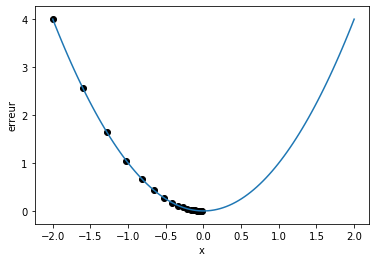

In [124]:
train_parameter(iterations_count=20)

#0 : loss = 0.640
#1 : loss = 0.102
#2 : loss = 0.016
#3 : loss = 0.003
#4 : loss = 0.000


(-0.020480000000000075, 0.00041943040000000305)

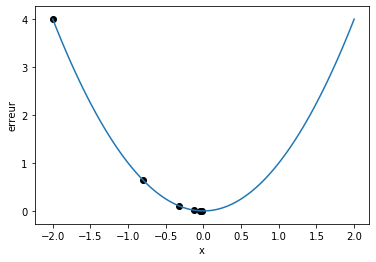

In [131]:
train_parameter(iterations_count=5,learning_rate=0.3)

#0 : loss = 5.760
#1 : loss = 8.294
#2 : loss = 11.944
#3 : loss = 17.199
#4 : loss = 24.767
#5 : loss = 35.664
#6 : loss = 51.357
#7 : loss = 73.954
#8 : loss = 106.493
#9 : loss = 153.350


(-12.383472844799353, 153.35039969788298)

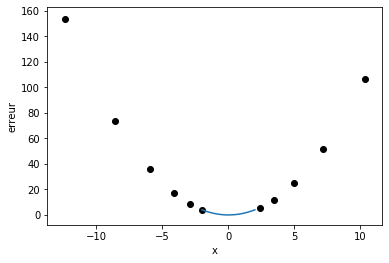

In [129]:
train_parameter(learning_rate=1.1)

### Gradient

Comme dans l'exemple ci-dessus, on peut essayer d'augmenter ou diminuer chaque paramètre à tour de rôle, puis tout recalculer et voir comment l'erreur évolue : ça fonctionne mais c'est évidemment beaucoup trop lent en pratique si on a une fonction de prédiction avec des millions de paramètres.

Dans le cadre du deep learning, on restreint en pratique le domaine recherche d'une fonction de prédiction infiniment flexible aux fonctions mathématiques *dérivables*, et on calcule la *dérivée partielle* de la fonction de mesure de l'erreur (loss function) par rapport à chacun de ses paramètres pour savoir comment les mettre à jour.

Dans ce contexte, on appelle **gradient** l'ensemble des valeurs des dérivées partielles de la fonction de mesure de l'erreur par rapport à la valeur actuelle des paramètrès du modèle.

Si vous avez oublié vos cours de lycée sur la dérivation des fonctions, ce n'est pas un problème : on va voir que le rôle de PyTorch est justement de calculer le gradient de la fonction de coût automatiquement.

In [144]:
x_val = tensor(-1.5).requires_grad_()

In [145]:
error_val = loss_function(x_val)
error_val

tensor(2.2500, grad_fn=<PowBackward0>)

In [146]:
# Calcul du gradient
error_val.backward()

In [147]:
# Récupération du gradient sur chaque paramètre
x_val.grad

tensor(-3.)

On retrouve ici directement la valeur "error_variation_when_x_changes" sans avoir à réévaluer le modèle et la fonction de mesure de l'erreur trois fois.

In [148]:
xs_val = tensor([3.,4.,10.]).requires_grad_()
xs_val

tensor([ 3.,  4., 10.], requires_grad=True)

Exemple similaire, mais cette fois avec une fonction de plusieurs paramètres :

In [153]:
def loss_func_vec(xs): return (xs**2).sum()

error_vec_val = loss_func_vec(xs_val)
error_vec_val

tensor(125., grad_fn=<SumBackward0>)

In [154]:
error_vec_val.backward()
xs_val.grad

tensor([12., 16., 40.])

IMPORTANT : utiliser Pytorch nécessite un changement de perspective => la dérivée / le gradient ne travaillent pas sur des fonctions, mais directement sur des variables qui ont une valeur. On ne calcule pas la fonction dérivée en général, mais sa valeur en un point précis.

### Exemple de SGD de bout en bout

Retour sur l'exemple de prédiction de la vitesse d'un wagon de grand huit en fonction du temps.

On génère ci-dessous des données de mesure fictive de ce phénomène.

In [155]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [161]:
# Introduction d'erreurs de mesures aléatoires pour avoir des données réalistes
# Distribution normale : moyenne 0 / écart type 1
measure_errors = torch.randn(20)
measure_errors, measure_errors.mean(), measure_errors.std()

(tensor([-0.0979, -0.0635, -0.0535,  0.7813, -0.0706,  0.1595, -0.1556,  1.5899,
          1.7567, -0.1262, -1.5276, -0.2620, -0.7876, -0.8350, -0.8353, -0.0914,
         -0.1685, -0.0819,  0.2114,  0.5367]),
 tensor(-0.0060),
 tensor(0.7645))

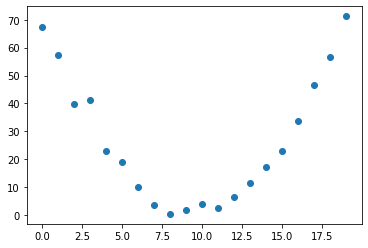

In [162]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

On suppose ci-dessous que la formule de calcul de la vitesse en fonction du temps n'est pas connue.

On essaie de l'approximer avec une fonction mathématique de la forme : vitesse(temps) = a * temps^2 + b * temps + c.

On va essayer de trouver les paramètres a,b,c qui permettent de mnimiser l'erreur de prédiction sur les points de mesure fictifs générés plus haut.

In [163]:
def model(time, params):
    a,b,c = params
    return a*(time**2) + (b*time) + c

In [164]:
def mean_squared_error(preds, targets): return ((preds-targets)**2).mean()

In [166]:
# Initialisation de 3 paramètres a,b,c au hasard
params = torch.randn(3).requires_grad_()

In [167]:
# Calcul des prédictions avec cette valeur initiale des paramètres
preds = model(time, params)

En bleu, la vitesse mesurée, en rouge la vitesse prédite :

In [170]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

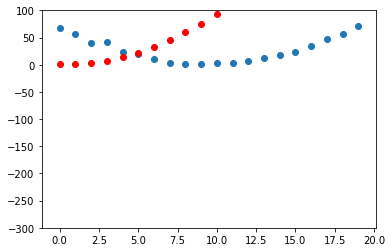

In [171]:
show_preds(preds)

In [172]:
# Calcul de l'erreur
loss = mean_squared_error(preds, speed)
loss

tensor(19456.7695, grad_fn=<MeanBackward0>)

In [173]:
# Calcul automatique du gradient par Pytorch pour chacun des trois paramètres
loss.backward()
params.grad

tensor([45999.6914,  2945.3848,   182.0449])

In [175]:
params

tensor([ 0.9974, -0.6020,  0.4083], requires_grad=True)

In [176]:
params.grad * 1e-5

tensor([0.4600, 0.0295, 0.0018])

In [177]:
# Faire un pas vers des meilleures valeurs de paramètres
lr = 1e-5
params.data = params.data - lr * params.grad.data
params.grad = None

In [179]:
# Vérifier l'amélioration de l'erreur
preds = model(time,params)
mean_squared_error(preds, speed)

tensor(4212.1221, grad_fn=<MeanBackward0>)

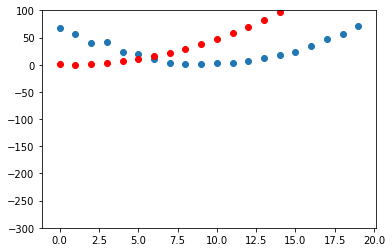

In [180]:
show_preds(preds)

In [181]:
def apply_step(params, prn=True):
    preds = model(time, params)
    loss = mean_squared_error(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [182]:
for i in range(10): apply_step(params)

4212.1220703125
1327.363037109375
781.4747314453125
678.17236328125
658.6209716796875
654.9176025390625
654.2131958007812
654.0762939453125
654.0467529296875
654.0374755859375


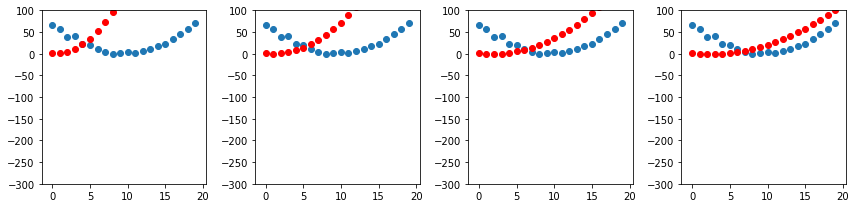

In [185]:
params = torch.randn(3).requires_grad_()
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

## Application au jeu de données MNIST

### Préparation des datasets d'entrainement et de validation

In [187]:
stacked_threes.shape,stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

[torch.cat(tensors, dim=0, out=None) → Tensor](https://pytorch.org/docs/stable/torch.html#torch.cat)

Concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be empty.

In [188]:
stacked_digits = torch.cat([stacked_threes, stacked_sevens])
stacked_digits.shape

torch.Size([12396, 28, 28])

[view(*shape) → Tensor](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view)
                        
Returns a new tensor with the same data as the self tensor but of a different shape.

In [189]:
train_x = stacked_digits.view(-1, 28*28) # the size -1 is inferred from other dimensions
train_x.shape

torch.Size([12396, 784])

In [190]:
stacked_labels = tensor([1]*len(threes) + [0]*len(sevens))
stacked_labels.shape

torch.Size([12396])

In [210]:
train_x[0,0],train_x[0,783]

(tensor(0.), tensor(0.))

In [211]:
stacked_labels[0,0]

IndexError: too many indices for tensor of dimension 1

[unsqueeze(dim) → Tensor](https://pytorch.org/docs/stable/torch.html#torch.unsqueeze)

Returns a new tensor with a dimension of size one inserted at the specified position.
The returned tensor shares the same underlying data with this tensor.

In [202]:
train_y = stacked_labels.unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [212]:
train_y[0,0]

tensor(1)

PyTorch définit un dataset comme une liste de couples (x,y).

On utilise la fonction Python zip(xs,ys) pour itérer en parallèle sur les deux listes xs et ys, et retourner une liste de couples [(x1,y1),(x2,y2), ...].

In [216]:
iterator = zip(train_x,train_y)
iterator

In [221]:
couple1 = next(iterator)
couple2 = next(iterator)
type(couple1),type(couple2),couple1[0].shape,couple1[1].shape,couple1[0].mean(),couple2[0].mean()

(tuple,
 tuple,
 torch.Size([784]),
 torch.Size([1]),
 tensor(0.1387),
 tensor(0.1703))

In [224]:
train_dataset = list(zip(train_x,train_y))
x,y = train_dataset[0]
len(train_dataset),x.shape,y

(12396, torch.Size([784]), tensor([1]))

On réalise la même mise en forme sur le **jeu de données de validation** :

In [225]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dataset = list(zip(valid_x,valid_y))

### Initialisation des paramètres et définition du modèle

In [226]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [227]:
weights = init_params((28*28,1))

In [228]:
bias = init_params(1)

In [232]:
train_x.shape,weights.shape,bias.shape

(torch.Size([12396, 784]), torch.Size([784, 1]), torch.Size([1]))

Calcul d'une prédiction :

In [233]:
(train_x[0]*weights.T).sum() + bias

tensor([4.0719], grad_fn=<AddBackward0>)

Intuitivement, on va essayer de trouver des paramètres avec une valeur très positive pour les pixels qui doivent être noirs dans un 3 et pas dans un 7, et une valeur très négative pour les pixels qui doivent être noirs dans un 7 et pas dans un 3.

Ainsi, le résultat obtenu sera très positif pour un 3, et très négatif pour un 7. Plus le résultat sera grand, plus on sera confiants pour prédire un 3.

Dans une approche similaire au broadcasting plus haut, il est beaucoup plus performant d'appliquer cette opération en masse sur tout un batch d'images, plutôt que dans une boucle image par image.

L'ajout de la dimension "batch" (prédiction pour plusieurs exemples en une opération) transforme le produit scalaire en un multiplication de matrices, opération optimisée par PyTorch et pour laquelle les GPUs ont été conçus.

Même sur un CPU, on calcule ci-dessous 12 400 prédictions en 4 ms.

In [236]:
def linear1(xb): return xb@weights + bias
%time preds = linear1(train_x)
len(preds),preds

Wall time: 4.8 ms


(12396,
 tensor([[  4.0719],
         [-12.2712],
         [  1.5993],
         ...,
         [ 20.3076],
         [ -6.9911],
         [  1.0647]], grad_fn=<AddBackward0>))

On va prédire un 3 chaque fois que le résultat est > 0, et un 7 chaque fois qu'il est <= 0.

Broadcasting à l'oeuvre ci-dessous :

In [237]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [ True],
        ...,
        [False],
        [ True],
        [False]])

In [238]:
accuracy = corrects.float().mean().item()
accuracy

0.46482735872268677

Puisqu'on a initialisé les paramètres au hasard, et qu'on avait une chance sur 2 de prédire le bon chiffre, on observe logiquement un taux de succès autour de 50% au départ.

Cette **métrique** accuracy est l'indicateur de performance qui nous intéresse.

Mais elle n'est pas adaptée comme mesure de l'erreur pour ajuster progressivement les paramètres : en effet, une petite amélioration sur un des paramètres ne se traduit pas par une petite réduction de l'erreur. 

Il y a une bascule "soudaine" d'une prédiction de correct à incorrect si on franchit le seuil de confiance, mais tant qu'on reste en dessous ou au dessus du seuil de confiance, des petites améliorations des valeurs ne modifient pas l'erreur mesurée. 

In [241]:
weights[0] *= 1.0001

In [242]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.46482735872268677

On n'a donc pas de signal, de gradient, pour guider l'amélioration progressive des paramètres.

Pour cette raison on utilise généralement deux fonctions de mesure de l'erreur :
- une **métrique** (metrics), indicateur de performance qui nous intéresse, juste affiché pour information
- une **fonction de coût** (loss function), utilisée pour guider l'amélioration progressive des paramètres, qui doit refléter de manière aussi "régulière" que possible les légères améliorations des valeurs de de paramètres par une légère diminution de la fonction de coût

Essayons de trouver une mesure de l'erreur plus "continue" pour notre jeu de données MNIST.

On doit prédire des labels qui sont 1 (trois) ou 0 (pas trois).

Supposons que notre modèle fournisse en sortie un nombre entre 0 et 1 : plus on est proche de 1, plus le modèle pense avoir reconnu un 3, plus on est proche de 0, moins le modèle pense avoir reconnu un 3.

On pourrait mesurer de manière continue notre distance à l'objectif, en sommant la distance de nos prédictions à 1 ou à 0, selon le label à prédire.

Exemple :

In [249]:
labels  = tensor([1,0,1])
preds   = tensor([0.9, 0.4, 0.2])

- si le label à prédire est 1 : distance à l'objectif = 1 - prédiction
- si le label à prédire est 0 : distance à l'objectif = prédiction - 0

In [247]:
labels==1

tensor([ True, False,  True])

In [248]:
torch.where(labels==1, 1-preds, preds)

tensor([0.1000, 0.4000, 0.8000])

In [250]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

Vérifions qu'une petite amélioration des prédictions se traduit bien de manière régulière par une petite amélioration de notre fonction de coût :

In [251]:
mnist_loss(preds,labels)

tensor(0.4333)

In [254]:
preds[2] += 0.1
mnist_loss(preds,trgts)

tensor(0.4000)

En l'état, notre modèle retourne des valeurs entre moins l'infini et plus l'inifini. 

Notre fonction de coût ne peut mesurer une distance au résultat attendu que si le modèle retourne des valeurs entre 0 et 1.

### Sigmoid

In [255]:
def sigmoid(x): return 1/(1+torch.exp(-x))

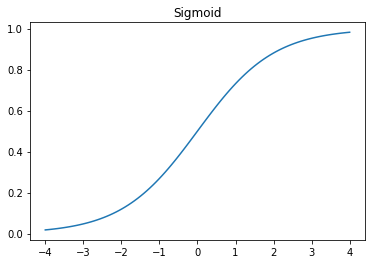

In [256]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

En appliquant la fonction sigmoid sur la sortie brute du modèle, on obtient un nombre entre 0 et 1 qu'on peut interpréter comme une **distance** au label 0 ou 1 en sortie du modèle.

Plus on est proche de 1, plus le modèle a été activé dans la direction d'une prédiction du label 1.
Plus on est proche de 0, plus le modèle a été activé dans la direction d'une prédiction du label 0.

ATTENTION : on ne peut en aucun cas interpréter ce nombre comme une **probabilité que la prédiction soit correcte**. Un modèle mal entrainé pourra tout à fait produire une prédiction très proche de 1 et se tromper grossièrement.

In [257]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD et mini-batchs

La mesure de l'erreur de prédiction par rapport aux résultats attends est le signal qui permet de calculer un gradient puis de faire un pas dans la bonne direction pour améliorer les paramètres.

Si on mesure cette erreur seulement sur deux ou trois exemples d'entrainement, on risque de faire un pas d'ajustement qui diminue l'erreur sur ces deux ou trois exemples particuliers, mais qui augmente l'erreur globalement sur tous les autres exemples.

Si on mesure cette erreur sur l'ensemble des exemples d'entrainement, on ne peut faire qu'un seul pas d'ajustement à chaque passage sur la totalité des données d'entrainement : l'entrainement va converger très lentement et durer un temps infini, on gâche beaucoup de capacités de calcul.

En pratique, on trouve un compromis en calculant l'erreur sur les données paquet par paquet (**mini-batchs** de données) :
- on choisit une **taille de batch** (le nombre d'exemples examinés à chaque itération) suffisamment grande pour que la mesure de l'erreur donne une bonne approximation du gradient sur l'ensemble du jeu d'entrainement
- on choisit une taille de batch suffisamment petite pour pouvoir appliquer un pas d'amélioration des paramètres du modèle aussi souvent que possible, réduire le temps de calul à chaque itération, pour accélérer la convergence du processus

De plus, les cartes graphiques (GPUs) sont optimisés pour réaliser les mêmes opérations simultanément sur un batch de données similaires. 

Concrètement, on sélectionne en général la taille des mini-batchs en **fonction de la capacité mémoire du GPU**, pour tirer le maximum des capacités de calcul du matériel. 

La **classe fastai2 Dataloader** a pour mission de créer des batches de données à partir d'un flux d'exemples fournis par une Datasource.

Pour apporter plus de variété à chaque époque et éviter une source potentielle de sur-spécialisation si on présentait de manière répétée toujours les mêmes batches dans la boucle d'apprentissage, on re-mélange les exemples de données de manière aléatoire en début de chaque époque avant de constituer des batchs.

In [258]:
coll = range(15)
list(coll)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [259]:
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 5,  8,  0, 14,  4]),
 tensor([1, 3, 6, 9, 2]),
 tensor([13, 10, 12,  7, 11])]

In [260]:
datasource = L(enumerate(string.ascii_lowercase)) # couples (x,y)
datasource

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [262]:
dl = DataLoader(datasource, batch_size=6, shuffle=True)
list(dl)

[(tensor([12, 19,  6, 23, 18, 11]), ('m', 't', 'g', 'x', 's', 'l')),
 (tensor([22, 20,  2, 25,  1, 21]), ('w', 'u', 'c', 'z', 'b', 'v')),
 (tensor([ 9,  0, 17, 24, 15,  4]), ('j', 'a', 'r', 'y', 'p', 'e')),
 (tensor([ 3, 14, 10, 16, 13,  7]), ('d', 'o', 'k', 'q', 'n', 'h')),
 (tensor([5, 8]), ('f', 'i'))]

## Réunir tous les éléments

In [281]:
# 0.a Initialisation des paramètres
weights = init_params((28*28,1))
bias = init_params(1)

In [282]:
# 0.b Création d'un Dataloader - training set
train_dl = DataLoader(train_dataset, batch_size=256)
xb,yb = first(train_dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [283]:
# 0.c Création d'un Dataloader - validation set
valid_dl = DataLoader(valid_dataset, batch_size=256)

In [284]:
# examen des 4 premiers exemples du premier batch d'entrainement
x4 = xb[:4]
y4 = yb[:4]
x4.shape,y4.shape

(torch.Size([4, 784]), torch.Size([4, 1]))

In [285]:
# 1. Calcul des prédictions avec le modèle "linear1"
preds = linear1(x4)
preds

tensor([[-2.2417],
        [-5.8228],
        [ 8.0869],
        [-0.0749]], grad_fn=<AddBackward0>)

In [286]:
# 2. Mesure de l'erreur - loss function
loss = mnist_loss(preds, y4)
loss

tensor(0.6050, grad_fn=<MeanBackward0>)

In [287]:
# 3. Calcul du gradient - dans quelle direction modifier les paramètres ?
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0142), tensor([-0.0849]))

In [288]:
# regroupement des 3 étapes précédentes dans une fonction unique
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [289]:
calc_grad(x4, y4, linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0284), tensor([-0.1699]))

In [290]:
calc_grad(x4, y4, linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0426), tensor([-0.2548]))

Attention, on voit ci-dessus que Pytorch accumule les gradients dans la même variable si on réalise plusieurs fois les calculs en boucle => il faut impérativement remettre les gradients à zéro entre deux itérations.

In [293]:
# remise à zéro des gradients
weights.grad.zero_()
bias.grad.zero_();

*Pourquoi PyTorch ne remet-il pas à zéro tout seul ? Dans des cas plus réalistes et plus complexes, on peut avoir des réseaux de neurones à plusieurs branches, et les gradients peuvent s'accumuler en provenance des différentes branches. PyTorch n'a pas moyen de savoir quand l'accumulation des gradients est terminée.*

In [294]:
# Regroupement des opérations d'entrainement d'une époque en une fonction
def train_epoch(model, lr, params):
    # - parcours des mini-batchs de données
    for xb,yb in dl:
        # - calcul du gradient sur un mini-batch
        calc_grad(xb, yb, model)
        # - ajustement des paramètres dans la direction inverse du gradient
        for p in params:
            p.data -= p.grad * lr # learning rate
            p.grad.zero_()        # remise à zéro du gradient de ce paramètre

Calcul de la métrique **accuracy** (taux de succès de la classification) sur un batch de données :
- seuil de prédiction du label 1 : sigmoid(prediction brute) > 0.5

In [298]:
def batch_accuracy(predsb, yb):
    preds01 = predsb.sigmoid()
    correct = (preds01 > 0.5) == yb
    return correct.float().mean()

In [300]:
batch_accuracy(linear1(x4), y4)

tensor(0.2500)

Calcul de la métrique accuracy sur l'ensemble du jeu de données de validation :

In [301]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [302]:
validate_epoch(linear1)

0.6424

Exécution manuelle de quelques époques d'entrainement :

In [303]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7221

In [304]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8759 0.9223 0.9418 0.9496 0.954 0.9579 0.9599 0.9618 0.9633 0.9638 0.9662 0.9672 0.9677 0.9692 0.9702 0.9702 0.9707 0.9707 0.9721 0.9721 

Nous venons d'entrainer un modèle qui classifie les chiffres manuscrits 3 et 7 avec 97.21% de succès.

### Créer un optimiseur

Mission : réaliser un pas d'ajustement des paramètres.

Le **module PyTorch nn.** stocke et initialise les paramètres d'un modèle linéraire comme celui que nous avons déifni plus haut à la main.

In [307]:
linear_model = nn.Linear(28*28,1)

In [308]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [309]:
class BasicOptim:
    def __init__(self,params,lr): 
        self.params = list(params)
        self.lr = lr

    def step(self):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self):
        for p in self.params: 
            p.grad = None

In [310]:
opt = BasicOptim(linear_model.parameters(), lr)

In [311]:
# Refactoring de la méthode train_epoch en utilisation un optimiseur
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Accuracy sur le jeu de validation avant entrainement : c'est juste pile ou face !

In [313]:
validate_epoch(linear_model)

0.502

In [314]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [315]:
train_model(linear_model, 20)

0.4932 0.8481 0.8325 0.9111 0.9351 0.9473 0.957 0.9624 0.9663 0.9678 0.9697 0.9726 0.9741 0.9751 0.9756 0.9765 0.9775 0.978 0.9785 0.9785 

L'**optimiseur PyTorch SGD** est l'équivalent de notre class BasciOptim.

Notre modèle et notre boucle d'entrainement peuvent être réécrits en trois lignes :

In [316]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8706 0.8149 0.9082 0.9312 0.9453 0.9546 0.9619 0.9653 0.9668 0.9687 0.9702 0.9731 0.9746 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

La **classe fastai2 Dataloaders** permet de regrouper les Dataloader des jeu de données d'entrainement et de validation :

In [317]:
dls = DataLoaders(train_dl, valid_dl)

La **classe fastai2 Learner** permet de regrouper :
- les jeux de données d'entrainement et de validation
- le modèle et ses paramètres
- l'optimiseur : opt_func
- la fonction de mesure de l'erreur pour calculer le gradient : loss_func
- les indictauers de performance qui intéressent le data scientist : matrics

In [318]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Sa **méthode fit(epochs, learning_rate)** est l'équivalent de notre fonction train_model :

In [319]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636752,0.503753,0.495584,00:00
1,0.630976,0.491005,0.495584,00:00
2,0.256827,0.317995,0.671737,00:00
3,0.109252,0.149172,0.866045,00:00
4,0.054400,0.096096,0.918057,00:00
5,0.033160,0.072651,0.935721,00:00
6,0.024458,0.059296,0.951914,00:00
7,0.020668,0.050791,0.957311,00:00
8,0.018839,0.045034,0.963690,00:00
9,0.017811,0.040926,0.965653,00:00


## Résumé de toute la leçon en une cellule

In [321]:
# Téléchargement du jeu de données
path = untar_data(URLs.MNIST_SAMPLE)

# Noms de fichiers pour les images de 3 et de 7
# - jeu d'entrainement
train_filenames_three = (path/'train'/'3').ls().sorted()
train_filenames_seven = (path/'train'/'7').ls().sorted()
# - jeu de validation
valid_filenames_three = (path/'valid'/'3').ls().sorted()
valid_filenames_seven = (path/'valid'/'7').ls().sorted()

# Chargement des images en mémoire sous la forme de tensors disjoints
# - jeu d'entrainement
train_tensors_three = [tensor(Image.open(o)) for o in train_filenames_three]
train_tensors_seven = [tensor(Image.open(o)) for o in train_filenames_seven]
# - jeu de validation
valid_tensors_three = [tensor(Image.open(o)) for o in valid_filenames_three]
valid_tensors_seven = [tensor(Image.open(o)) for o in valid_filenames_seven]

# Regroupement de toutes les images et de tous les labels dans un tensor unique
# - jeu d'entrainement
train_xs = torch.cat([torch.stack(train_tensors_three),torch.stack(train_tensors_seven)]).view(-1,28*28)
train_ys = tensor([1]*len(train_tensors_three) + [0]*len(train_tensors_seven)).unsqueeze(1)
# - jeu de validation
valid_xs = torch.cat([torch.stack(valid_tensors_three),torch.stack(valid_tensors_seven)]).view(-1,28*28)
valid_ys = tensor([1]*len(valid_tensors_three) + [0]*len(valid_tensors_seven)).unsqueeze(1)

# Création de datasets : itérateurs qui renvoient des couples (image,label)
train_dataset = zip(train_xs,train_ys)
valid_dataset = zip(valid_xs,valid_ys)

# Création de Dataloaders : itérateurs qui renvoient des mini-batchs (256 images, 256 labels)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=True)
dataloaders = DataLoaders(train_dl, valid_dl)

# Choix d'un simple modèle linéaire et initialisation de ses paramètres
model = nn.Linear(28*28,1)

# Définition de la fonction de mesure de l'erreur
# (pour calcul du gradient)
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

# Choix d'un optimiseur
optim = SGD
# Choix learning rate
lr = 1.

# Définition de la métrique de performance qui nous intéresse
# (pour affichage à chaque fin d'époque)
def batch_accuracy(predsb, yb):
    preds01 = predsb.sigmoid()
    correct = (preds01 > 0.5) == yb
    return correct.float().mean()

# Création d'un objet Learner
# - choix du modèle : nn.Linear
# - choix de l'optimiseur : SGD
learn = Learner(dataloaders, 
                model,
                loss_func=mnist_loss, opt_func=optim,
                metrics=batch_accuracy)

# Ajustement des paramètres sur 10 époques
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637089,0.502714,0.495584,00:00
1,0.368135,0.282077,0.726202,00:00
2,0.141063,0.153626,0.862610,00:00
3,0.065286,0.096650,0.917566,00:00
4,0.037149,0.072681,0.936212,00:00
5,0.025981,0.059219,0.949951,00:00
6,0.021270,0.050670,0.957802,00:00
7,0.019085,0.044903,0.964181,00:00
8,0.017915,0.040799,0.966143,00:00
9,0.017175,0.037741,0.968106,00:00


On retrouve une performance de classification finale de l'ordre de 97%.

Pour aller plus loin, on peut remplacer notre modèle linéaire par un modèle un tout petit peu plus compliqué : des combinaisons de segments au lieu de simples droites. 

On définit ainsi un réseau de neurones.

## Création d'un réseau de neurones à un niveau

In [322]:
def simple_net(xb): 
    res = xb@w1 + b1             # droites
    res = res.max(tensor(0.0))   # segments de droites
    res = res@w2 + b2            # combinaison de segments de droites
    return res

In [323]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

PyTorch définit la fonction **F.relu : Rectified Linear Unit**, qui est juste l'équivalent de max(x,0)

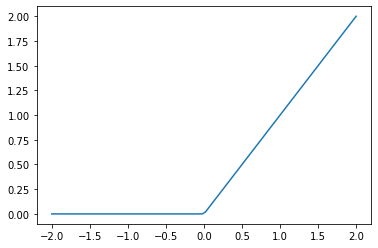

In [325]:
plot_function(F.relu)            # équivalent de : res.max(tensor(0.0)) 

Un niveau de **réseau de neurone** (feed-forward ou fully-connected) se traduit par l'enchainement des 3 modules suivants :
- production de 30 combinaisons linéaires différentes des 28*28 paramètres d'entrée (23 550 paramètres à ajuster)
- ajout d'une non linéarité (création de "segments de droite" à combiner)
- combinaisation linéaire des 30 valeurs intermédiaires pour produire une prédiction (31 paramètres à ajuster)

In [326]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

Essayons d'entrainer ce nouveau modèle de la même manière :
- le précédent modèle avait 785 paramètres à ajuster
- le nouveau modèle a 23 581 paramètres à ajuster (30x plus de capacité de calcul)

In [350]:
learn = Learner(dls, simple_net, opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy,
               cbs=ShowGraphCallback())

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.011098,0.017930,0.983317,00:00
1,0.011062,0.017900,0.983317,00:00
2,0.011020,0.017871,0.983317,00:00
3,0.010976,0.017843,0.983317,00:00
4,0.010930,0.017816,0.982826,00:00
5,0.010884,0.017789,0.982826,00:00
6,0.010839,0.017764,0.983317,00:00
7,0.010794,0.017740,0.983317,00:00
8,0.010750,0.017716,0.983317,00:00
9,0.010707,0.017693,0.983317,00:00


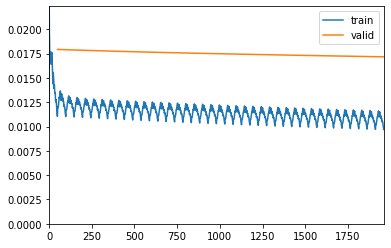

In [351]:
learn.fit(40, 0.1)

In [352]:
learn.recorder.values[-1][2]

0.9852796792984009

Nouvelle tentative avec un réseau de neurones à 18 niveaux : **retour aux 3 lignes de code de la précédente session**
- le précédent modèle avait 23 581 paramètres à ajuster
- le nouveau modèle a 17986 paramètres à ajuster (2x moins de capacité de calcul)
- mais le nouveau modèle a une architecture beaucoup mieux adaptée au problème
- l'étude de cette architecture sera l'objet d'une prochaine session

In [ ]:
dls = ImageDataLoaders.from_folder(path,bs=32)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

On atteint un taux de succès de classification de **99.7%** en 10 secondes.

In [373]:
# nombre de paramètres du modèle
np.sum([len(layerparams.data) for layerparams in learn.model.parameters()])

17986